# <font color="Green">Installation</font>

In [ ]:
! pip install ultralytics

# <font color="Green">Export</font>

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo26n.pt")
path = model.export(format="onnx", opset=13)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
YOLO26n summary (fused): 122 layers, 2,408,932 parameters, 0 gradients, 5.4 GFLOPs

PyTorch: starting from 'yolo26n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.3 MB)

ONNX: starting export with onnx 1.20.1 opset 13...


/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/symbolic_opset9.py:5353: UserWarning: Exporting aten::index operator of advanced indexing in opset 13 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


ONNX: slimming with onnxslim 0.1.84...
ONNX: export success ✅ 2.2s, saved as 'yolo26n.onnx' (9.5 MB)

Export complete (3.5s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo26n.onnx imgsz=640 
Validate:        yolo val task=detect model=yolo26n.onnx imgsz=640 data=/home/lq/codes/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


# <font color="Green">Implementation</font>

Inference successful! Detections:

Box: [264, 343, 1622, 1137]  Conf: 0.95
Box: [55, 735, 258, 1302]  Conf: 0.90
Box: [1587, 792, 1694, 972]  Conf: 0.77
Box: [241, 951, 554, 1302]  Conf: 0.54


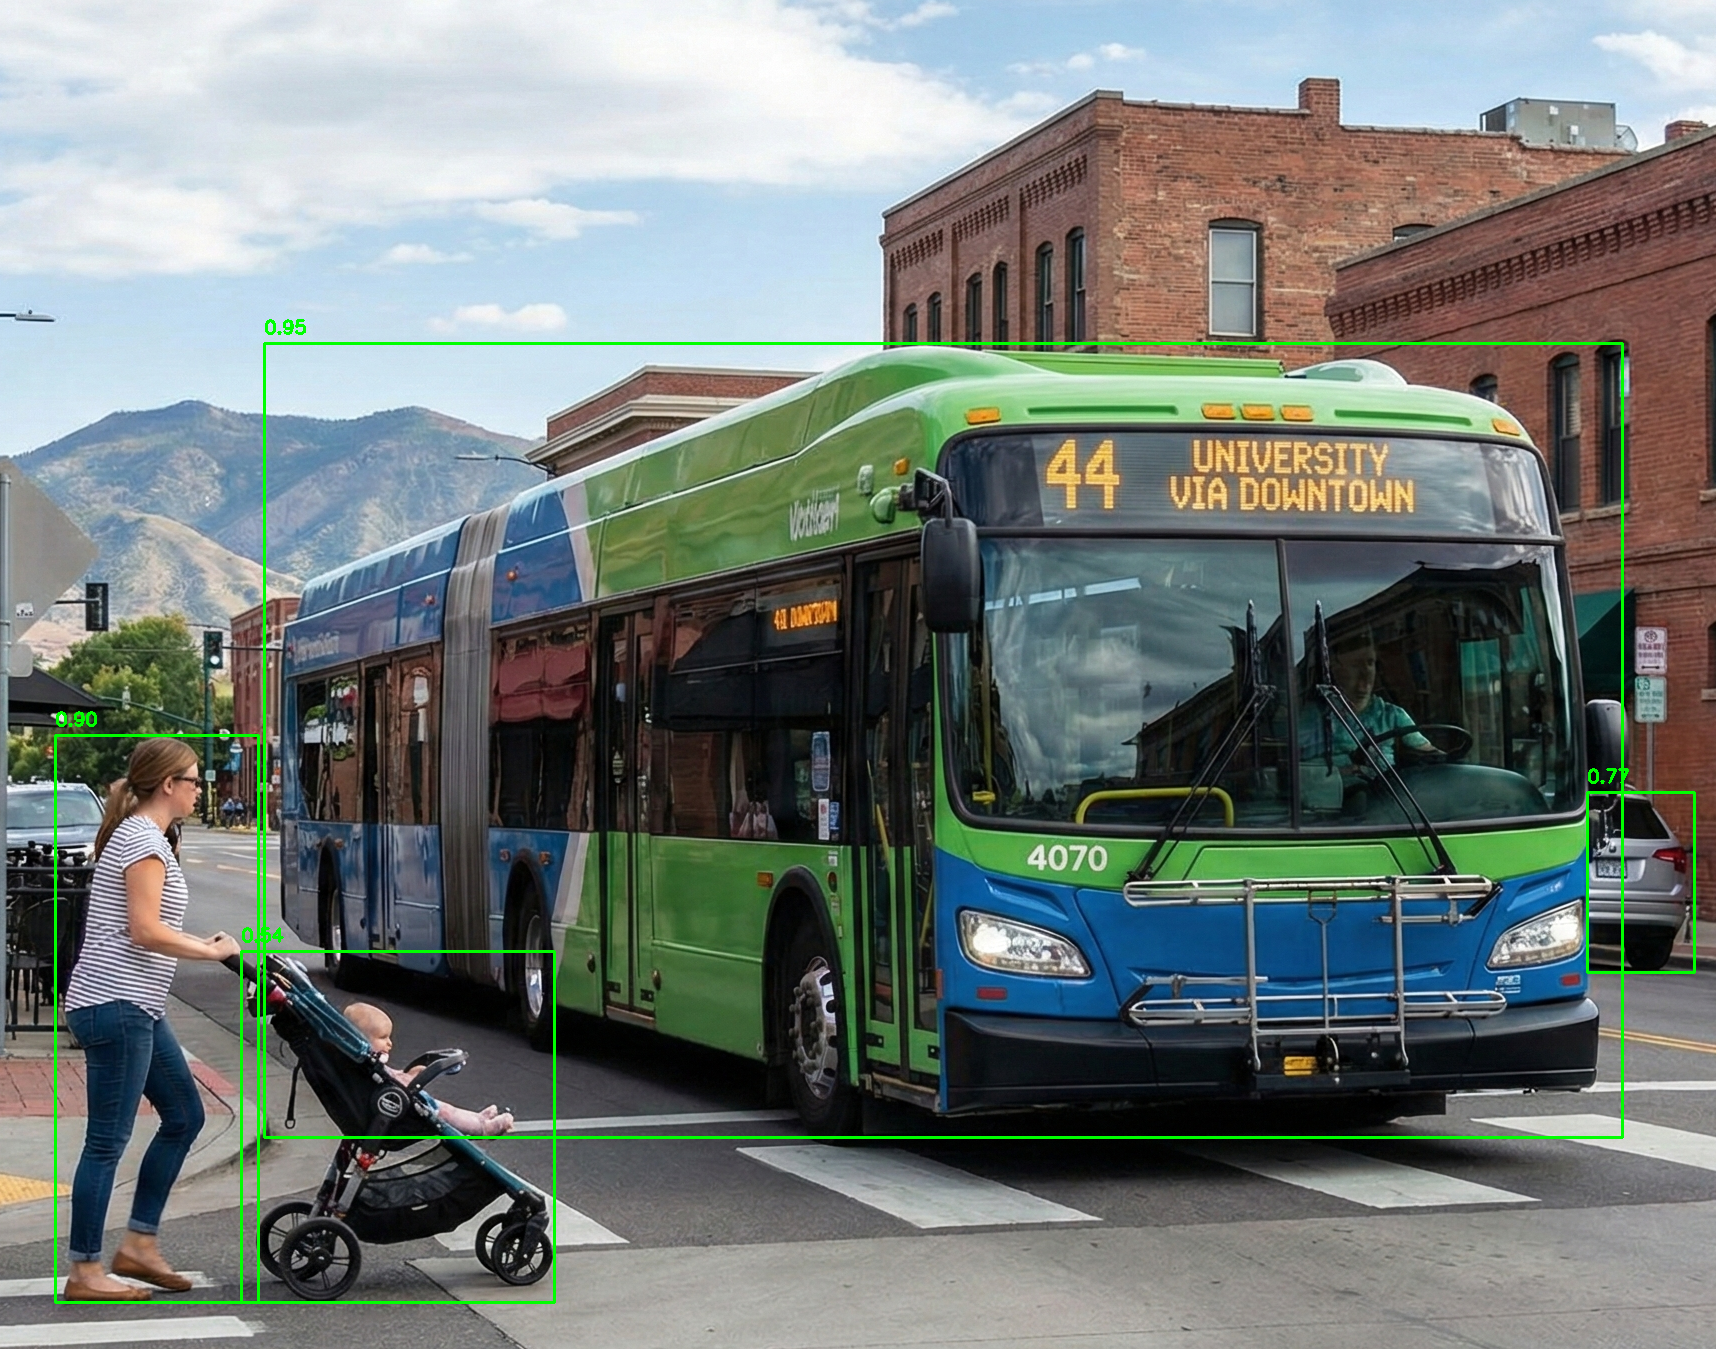


Saved to result_yolo26.jpg


In [ ]:
import onnxruntime
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# ===============================
# 1. Load image
# ===============================
image_path = "example.jpg"
original_img = cv2.imread(image_path)

if original_img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

h_orig, w_orig = original_img.shape[:2]

# ===============================
# 2. Preprocess
# ===============================
img = cv2.resize(original_img, (640, 640))
img = img.astype(np.float32) / 255.0
img = img.transpose(2, 0, 1)          # HWC -> CHW
image_data = np.expand_dims(img, 0)   # add batch

# ===============================
# 3. Inference
# ===============================
session = onnxruntime.InferenceSession("yolo26n.onnx")
inputs = {session.get_inputs()[0].name: image_data}
outputs = session.run(None, inputs)[0]

# ===============================
# 4. Post-process & Draw
# ===============================
scale_x = w_orig / 640
scale_y = h_orig / 640

print("Inference successful! Detections:\n")

for box in outputs[0]:
    conf = float(box[4])
    if conf > 0.5:
        x1, y1, x2, y2 = box[:4]

        # rescale
        x1 = int(x1 * scale_x)
        y1 = int(y1 * scale_y)
        x2 = int(x2 * scale_x)
        y2 = int(y2 * scale_y)

        print(f"Box: {[x1,y1,x2,y2]}  Conf: {conf:.2f}")

        # draw
        cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(original_img, f"{conf:.2f}", (x1, max(20, y1-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# ===============================
# 5. Show + Save
# ===============================
cv2_imshow(original_img)        # <-- shows in Colab
cv2.imwrite("result_yolo26.jpg", original_img)

print("\nSaved to result_yolo26.jpg")
